# Bottle Data

### Purpose
This notebook provides a quick outline and example of working with OOI Discrete Summary Spreadsheet bottle data. It includes how to load it, how to parse data quality flags, how to derive some important values, etc.

At each [boiler plate stuff about OOI cruises]

### Data
The cruise data is hosted on OOI's Alfresco document server at https://alfresco.oceanobservatories.org, hereafter reffered to as Alfresco. Cruise data is hosted under OOI > {Array} > Cruise Data > {Cruise}. Cruise data includes the following key pieces of information: Cruise Reports, Ship Data (e.g. sonars, underway instruments, etc.), CTD and Water Sampling Data.

We are principally concerned with the Water Sampling data, which can be found under {Cruise} > Ship Data > Water Sampling. The Water Sampling folder contains both digitized and scanned CTD logs as well as the results from the labs for each .

In [1]:
import os, sys, re
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sys.path.append("..")
from bottle_utils import *

---
### Niskin & Discrete Bottle Sampling
These are discrete water samples collected via Niskin Bottle casts during deployment and recovery of the moored instrumentation. The data is downloaded from OOI Alfresco website as excel files. Parameters sampled are:
* Oxygen
* Salinity
* Nutrients: phosphate, nitrate, nitrite, ammonium, silicate
* Chlorophyll
* Carbon system: Dissolved inorganic carbon, total alkalinity, pH

First, we're going to load, clean, and process the discrete water sampling.

In [3]:
bottle_data = pd.read_excel("../data/bottle_data/Irminger_Sea-02_AT30-01_Discrete_Summary.xlsx")
bottle_data.head()

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Discrete pH Replicate Flag,Calculated Alkalinity [umol/kg],Calculated DIC [umol/kg],Calculated pCO2 [uatm],Calculated pH,Calculated CO2aq [umol/kg],Calculated Bicarb [umol/kg],Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A
0,AT30-01,1,release test,42.547833,-62.584,2015-08-07T12:39:53.000Z,1,*0000000000000100,1723,C:\data\ctd\at30_001.hex,...,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999
1,AT30-01,1,release test,42.547833,-62.584,2015-08-07T12:39:53.000Z,1,*0000000000000100,1723,C:\data\ctd\at30_001.hex,...,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999
2,AT30-01,1,release test,42.547833,-62.584,2015-08-07T12:39:53.000Z,1,*0000000000000100,1723,C:\data\ctd\at30_001.hex,...,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999
3,AT30-01,1,release test,42.547833,-62.584,2015-08-07T12:39:53.000Z,1,*0000000000000100,1723,C:\data\ctd\at30_001.hex,...,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999
4,AT30-01,1,release test,42.547833,-62.584,2015-08-07T12:39:53.000Z,1,*0000000000000100,1723,C:\data\ctd\at30_001.hex,...,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999,-9999999


Replace the fill value of ```-9999999``` with NaNs. Some columns were imported as floats and others as strings or objects, so this needs to be done twice:

In [4]:
bottle_data = bottle_data.replace(to_replace="-9999999", value=np.nan)
bottle_data = bottle_data.replace(to_replace=-9999999, value=np.nan)

Convert times from strings to pandas datetime objects and remove the timezone:

In [5]:
bottle_data["Start Time [UTC]"] = bottle_data["Start Time [UTC]"].apply(lambda x: convert_times(x))
bottle_data["CTD Bottle Closure Time [UTC]"] = bottle_data["CTD Bottle Closure Time [UTC]"].apply(lambda x: convert_times(x))

Some of the data returned from the labs which process samples contain non-numeric indicators for if data were below detection threshold. These entries typically have a "less than" sign. Convert any values with a "<", which indicates a value not statistically significant from zero, with zero:

In [6]:
bottle_data = bottle_data.applymap(not_statistically_sigificant)

#### Filter data
Next, we want to filter the data based on the data flag associated with the sample. First, we should drop all of the ```NaN``` values in the Niskin column to eliminate entries without any bottle samples. While these CTD casts may be of interest, the bottle data does not have any data of which we can make use of.

In [7]:
bottle_data = bottle_data.dropna(subset=["Niskin/Bottle Position"])

#### Interpret Flags
Next, we want to parse the Data Quality Flags in the bottle data. 

We intrept the data into the standard QARTOD flaging scheme of:
* 1 = good
* 2 = not run
* 3 = suspect
* 4 = bad
* 9 = missing

The "Replicate Flags" are reduced into a boolean value indicating that either there is a replicate sample or not. By replicate, we mean if there are more than one sample collected from a depth, e.g. two Niskins were closed at a particular depth and oxygen sampled from both. It does *not* mean that a particular analysis was repeated on the same sample multiple times, e.g. repeating nutrient analysis on a single Niskin to derive a final value.

In [8]:
for col in bottle_data.columns:
    if "Flag" in col:
        if "CTD" in col and "File" not in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_ctd_flag(x))
        elif "Discrete" in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_discrete_flag(x))
        elif "Replicate" in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_replicate_flag(x))
        elif "Niskin" in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_niskin_flag(x))
        else:
            pass

---
### Calculate Physical Properties
With the bottle samples cleaned up and the flags parsed into something simpler and easier to read, we next want to calculate the conservative seawater properties, such as density, conservative temperature, absolute salinity, etc., using the updated Thermodynamic Equations of State - 2010 (TEOS-10) algorithms. These are implemented with the ```gsw``` package. 

This step will allow us to correct for pressure and temperature effect between lab analysis and in-situ measurements, as well as allow for better comparison between depths and locations in the same array. 

In [9]:
import gsw

Get the measured parameters, taking the average if measured by more than one sensor

In [10]:
SP = bottle_data[["CTD Salinity 1 [psu]", "CTD Salinity 2 [psu]"]].mean(axis=1, skipna=True)
T = bottle_data[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].mean(axis=1, skipna=True)
P = bottle_data["CTD Pressure [db]"]
LAT = bottle_data["CTD Latitude [deg]"]
LON = bottle_data["CTD Longitude [deg]"]

Calculate the conservative temperature, absolute salinity, density, and potential density of the observations

In [11]:
# Absolute salinity
SA = gsw.conversions.SA_from_SP(SP, P, LON, LAT)
bottle_data["CTD Absolute Salinity [g/kg]"] = SA

# Conservative temperature
CT = gsw.conversions.CT_from_t(SA, T, P)
bottle_data["CTD Conservative Temperature"] = CT

# Density
RHO = gsw.density.rho(SA, CT, P)
bottle_data["CTD Density [kg/m^3]"] = RHO

# Calculate potential density
SIGMA0 = gsw.density.sigma0(SA, CT)
bottle_data["CTD Sigma [kg/m^3]"] = RHO

del SP, T, P, LAT, LON, SA, CT, RHO, SIGMA0

---
## Calculate Carbon System Parameters
The discrete water samples were tested for Total Alkalinity, Dissolved Inorganic Carbon, and pH [Total Scale]. We can calculate the discrete water sample pCO<sub>2</sub> concentrations from the TA and DIC using the ```CO2SYS``` program. Implementation in python is achieved using the PyCO2SYS package. Full documentation on how to install and use PyCO2SYS can be found at https://pyco2sys.readthedocs.io/en/latest/. 

For our purposes, we will be utilizing the following inputs:
* ```PAR1```: First measured carbon system measurement
* ```PAR2```: Second measured carbon system measurement
* ```PAR1_type```: The type of PAR1 
        * 1 = Total Alkalinity umol/kg
        * 2 = DIC umol/kg
        * 3 = pH Total Scale
        * 4 = pCO2
        * 5 = fCO2
* ```PAR2_type```: The type of PAR2


We will also use the following optional hydrographic inputs:
* ```salinity```: practical salinity
* ```temperature```: the temperature at which PAR1 and PAR2 are provided (in C)
* ```pressure```: the water pressure at which ```PAR1``` and ```PAR2``` are measured

Additionally, we will pass in some of the nutrient data that we collect:
* ```SIO4```: discrete silicate
* ```PO4```: discrete phosphate
* ```NH4```: discrete ammonia

The nutrient values need to be (1) converted to umol/kg from uM and (2) have NaNs filled in with 0, which is the default value.

In [12]:
import PyCO2SYS as pyco2

In [20]:
# Get the key parameters
DIC = bottle_data["Discrete DIC [umol/kg]"]
TA = bottle_data["Discrete Alkalinity [umol/kg]"]
PH = bottle_data["Discrete pH [Total scale]"]
SAL = bottle_data["Discrete Salinity [psu]"]

# Set the input hydrographic parameters at which the DIC/TA/pH lab measurements were performed
TEMP_IN = 25
PRES_IN = 0

# Get the hydrographic parameters at which the samples were taken
TEMP_OUT = bottle_data[["CTD Temperature 1 [deg C]","CTD Temperature 1 [deg C]"]].mean(axis=1, skipna=True)
PRES_OUT = bottle_data["CTD Pressure [db]"]
RHO = bottle_data["CTD Density [kg/m^3]"]

# Nutrient inputs = need to fill NaNs with zeros otherwise will return NaNs
SIO4 = bottle_data["Discrete Silicate [uM]"].fillna(value=0)
PO4 = bottle_data["Discrete Phosphate [uM]"].fillna(value=0)
NH4 = bottle_data["Discrete Ammonium [uM]"].fillna(value=0)

# Convert to umol/kg
SIO4 = SIO4*(1000/1)*(1/RHO)
PO4 = PO4*(1000/1)*(1/RHO)
NH4 = NH4*(1000/1)*(1/RHO)

Declare the parameter input types to pass into ```CO2SYS```

In [21]:
PAR1 = bottle_data['Discrete Alkalinity [umol/kg]']
PAR2 = bottle_data['Discrete DIC [umol/kg]']
PAR1TYPE = 1
PAR2TYPE = 2
PHSCALEIN = 1
K1K2CONSTANTS = 1
K2SO4CONSTANTS = 1

#### Calculate Carbon System
With all of the mandatory and optional carbon system parameters selected, we now calculate the carbon system for the bottle data

In [22]:
CO2dict = pyco2.CO2SYS(PAR1, PAR2, PAR1TYPE, PAR2TYPE, SAL, TEMP_IN, TEMP_OUT, PRES_IN, PRES_OUT, SIO4, PO4, PHSCALEIN, K1K2CONSTANTS, K2SO4CONSTANTS)

Now add the calculate carbon system parameters to the bottle data

In [25]:
bottle_data['Calculated Alkalinity [umol/kg]'] = CO2dict['TAlk']
bottle_data['Calculated CO2aq [umol/kg]'] = CO2dict['CO2out']
bottle_data['Calculated CO3 [umol/kg]'] = CO2dict['CO3out']
bottle_data['Calculated DIC [umol/kg]'] = CO2dict['TCO2']
bottle_data['Calculated pCO2 [uatm]'] = CO2dict['pCO2out']
bottle_data['Calculated pCO2in'] = CO2dict['pCO2in']
bottle_data['Calculated pH'] = CO2dict['pHinTOTAL']

Add in error propagation here:

### Assessment
We can check on how well ```CO2SYS``` reconstructed the carbon system by comparing the **Calculated pH**, derived from the DIC and TA, against the **Discrete pH**. This serves as an independent check and bound on the error introduced by the carbonate system algorithms. 

In [26]:
bottle_data[["Discrete pH [Total scale]","Calculated pH"]].dropna()

,Discrete pH [Total scale],Calculated pH
42,7.7018,7.729633
47,7.8202,7.844386
48,7.8196,7.884067
50,7.8268,7.841813
123,7.8240,7.836911
135,7.7386,7.754857
148,7.8202,7.827224
167,7.7192,7.726856
172,7.8336,7.823105
173,7.8332,7.815021


With the comparison, we can calculate the 

In [28]:
PHout = CO2dict["pHinTOTAL"]
df = pd.DataFrame(data=[PH.values, PHout], index=["Measured", "CO2sys"]).T.dropna()
df = df[df["CO2sys"] > 7]
df = df.sort_values(by="Measured")
PHmeas = df["Measured"].values.reshape(-1,1)
PHcalc = df["CO2sys"].values.reshape(-1,1)

In [30]:
# Use sklearn linear regression model to determine the accuracy 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Fit a linear regression to the measured vs calculated pH values
regression = LinearRegression()
regression.fit(PHmeas, PHcalc)

# Get the regression values
PHpred = regression.predict(PHmeas)
PHmse = mean_squared_error(PHpred, PHcalc)
PHstd = np.sqrt(PHmse)

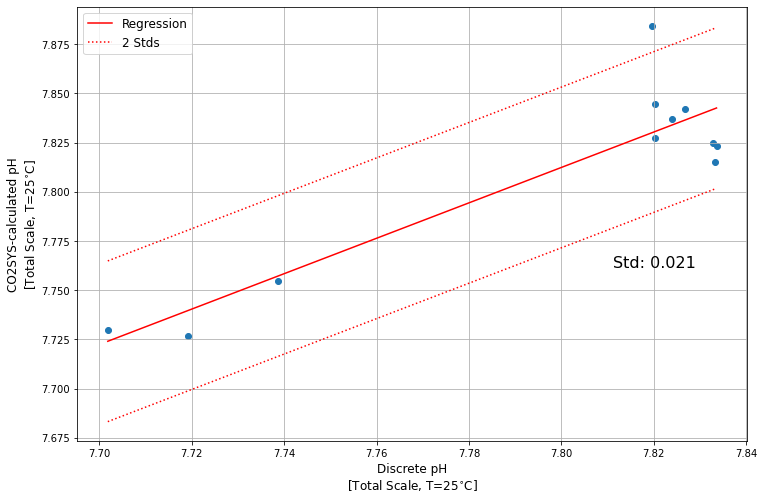

In [35]:
# Look at how closely the pH measurements match each other
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
ax.scatter(PHmeas, PHcalc)
ax.plot(PHmeas, PHpred, c='r', label='Regression')

#ax.fill_between(PHmeas, PHpred-1.96*PHstd, PHpred+1.96*PHstd, color="tab:red")
ax.plot(PHmeas, PHpred-1.96*PHstd, ':', c='r', label='2 Stds')
ax.plot(PHmeas, PHpred+1.96*PHstd, ':', c='r')
ax.set_xlabel('Discrete pH\n[Total Scale, T=25$^{\circ}$C]', fontsize=12)
ax.set_ylabel('CO2SYS-calculated pH\n[Total Scale, T=25$^{\circ}$C]', fontsize=12)
ax.text(0.8,0.4,f'Std: {PHstd.round(3)}', fontsize='16', transform=ax.transAxes)
ax.legend(fontsize=12)
ax.grid()

In [38]:
regression.coef_, regression.intercept_

(array([[0.89931728]]), array([0.79766301]))